In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader, random_split
from torch_pconv import PConv2d  # Partial convolution layer; ensure this is installed.

In [2]:
class ImageInpaintingDatasetCSV(Dataset):
    def __init__(self, csv_file, img_size=(240, 320), mask_size=(64, 64), transform=None, apply_mask=True):
        self.data = pd.read_csv(csv_file, header=None)  # Adjust header if needed.
        self.color_paths = self.data.iloc[:, 0].tolist()
        self.depth_paths = self.data.iloc[:, 1].tolist()  # Not used here.
        self.img_size = img_size
        self.mask_size = mask_size
        self.transform = transform
        self.apply_mask = apply_mask

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        color_path = self.color_paths[idx]
        path = "..\\nyu_data\\" + color_path
        img = cv2.imread(path)
        if img is None:
            raise ValueError(f"Image not found: {color_path}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (self.img_size[1], self.img_size[0]))
        img = img.astype(np.float32) / 255.0
        H, W, _ = img.shape

        if self.apply_mask:
            mask = self.create_square_mask((H, W), self.mask_size)  # 0 for masked, 255 for unmasked.
            masked_img = img.copy()
            mask_3d = np.stack([mask] * 3, axis=-1)
            masked_img[mask_3d == 0] = 0.0
        else:
            mask = np.ones((H, W), dtype=np.uint8) * 255
            masked_img = img

        # Convert to torch tensors.
        img_tensor = torch.from_numpy(img).permute(2, 0, 1)  # (3, H, W)
        masked_tensor = torch.from_numpy(masked_img).permute(2, 0, 1)
        mask_tensor = torch.from_numpy(mask.astype(np.float32) / 255.0).unsqueeze(0)  # (1, H, W)

        if self.transform:
            img_tensor = self.transform(img_tensor)
            masked_tensor = self.transform(masked_tensor)
            mask_tensor = self.transform(mask_tensor)
        
        return {
            "image": img_tensor,
            "masked_image": masked_tensor,
            "mask": mask_tensor
        }
    
    def create_square_mask(self, image_size, mask_size):
        H, W = image_size
        mH, mW = mask_size
        mask = np.ones((H, W), dtype=np.uint8) * 255
        top = np.random.randint(0, H - mH + 1)
        left = np.random.randint(0, W - mW + 1)
        mask[top:top+mH, left:left+mW] = 0
        return mask

In [3]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super(EncoderBlock, self).__init__()
        self.pconv1 = PConv2d(in_channels, out_channels, kernel_size=kernel_size, 
                              stride=1, padding=padding, bias=True)
        self.pconv2 = PConv2d(out_channels, out_channels, kernel_size=kernel_size, 
                              stride=2, padding=padding, bias=True)
    
    def forward(self, x, mask):
        if mask.dim() == 4 and mask.size(1) == 1:
            mask = mask.squeeze(1)
        x1, mask1 = self.pconv1(x, mask)
        x1 = F.relu(x1)
        x2, mask2 = self.pconv2(x1, mask1)
        x2 = F.relu(x2)
        return x1, mask1, x2, mask2

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels1, out_channels2, kernel_size=3, padding=1):
        super(DecoderBlock, self).__init__()
        self.pconv1 = PConv2d(skip_channels + in_channels, out_channels1, kernel_size=kernel_size, 
                              stride=1, padding=padding, bias=True)
        self.pconv2 = PConv2d(out_channels1, out_channels2, kernel_size=kernel_size, 
                              stride=1, padding=padding, bias=True)
    
    def forward(self, x, mask, skip_x, skip_mask):
        x_up = F.interpolate(x, scale_factor=2, mode='nearest')
        if mask.dim() == 4 and mask.size(1) == 1:
            mask = mask.squeeze(1)
        mask_up = F.interpolate(mask.unsqueeze(1), scale_factor=2, mode='nearest').squeeze(1)
        if skip_mask.dim() == 4 and skip_mask.size(1) == 1:
            skip_mask = skip_mask.squeeze(1)
        mask_cat = torch.max(skip_mask, mask_up)
        x_cat = torch.cat([skip_x, x_up], dim=1)
        x1, mask1 = self.pconv1(x_cat, mask_cat)
        x1 = F.relu(x1)
        x2, mask2 = self.pconv2(x1, mask1)
        x2 = F.relu(x2)
        return x1, mask1, x2, mask2

class InpaintingModel(nn.Module):
    def __init__(self, input_channels=3, output_channels=3):
        super(InpaintingModel, self).__init__()
        self.enc1 = EncoderBlock(input_channels, 8)
        self.enc2 = EncoderBlock(8, 16)
        self.enc3 = EncoderBlock(16, 32)
        self.enc4 = EncoderBlock(32, 64)

        self.dec1 = DecoderBlock(64, 64, 64, 32)
        self.dec2 = DecoderBlock(32, 32, 32, 16)
        self.dec3 = DecoderBlock(16, 16, 16, 8)
        self.dec4 = DecoderBlock(8, 8, 8, output_channels)
        self.final_conv = nn.Conv2d(output_channels, output_channels, kernel_size=3, padding=1)
    
    def forward(self, x, mask):
        if mask.dim() == 4 and mask.size(1) == 1:
            mask = mask.squeeze(1)
        conv1, mask1, conv2, mask2 = self.enc1(x, mask)
        conv3, mask3, conv4, mask4 = self.enc2(conv2, mask2)
        conv5, mask5, conv6, mask6 = self.enc3(conv4, mask4)
        conv7, mask7, conv8, mask8 = self.enc4(conv6, mask6)

        dec1, dmask1, dec1_out, dmask1_2 = self.dec1(conv8, mask8, conv7, mask7)
        dec2, dmask2, dec2_out, dmask2_2 = self.dec2(dec1_out, dmask1_2, conv5, mask5)
        dec3, dmask3, dec3_out, dmask3_2 = self.dec3(dec2_out, dmask2_2, conv3, mask3)
        dec4, dmask4, dec4_out, dmask4_2 = self.dec4(dec3_out, dmask3_2, conv1, mask1)
        out = self.final_conv(dec4_out)
        
        return torch.sigmoid(out)

In [4]:
def dice_coef(y_true, y_pred, epsilon=1e-6):
    y_true_f = y_true.view(-1)
    y_pred_f = y_pred.view(-1)
    intersection = (y_true_f * y_pred_f).sum()
    return (2. * intersection + epsilon) / (y_true_f.sum() + y_pred_f.sum() + epsilon)

In [5]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for batch in tqdm(dataloader):
        masked_image = batch["masked_image"].to(device)
        mask = batch["mask"].to(device)
        target = batch["image"].to(device)
        
        optimizer.zero_grad()
        output = model(masked_image, mask)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * masked_image.size(0)
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    total_dice = 0.0
    with torch.no_grad():
        for batch in dataloader:
            masked_image = batch["masked_image"].to(device)
            mask = batch["mask"].to(device)
            target = batch["image"].to(device)
            output = model(masked_image, mask)
            loss = criterion(output, target)
            running_loss += loss.item() * masked_image.size(0)
            total_dice += dice_coef(target, output).item() * masked_image.size(0)
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_dice = total_dice / len(dataloader.dataset)
    return epoch_loss, epoch_dice

In [6]:
train_csv = r"C:\Users\user\Desktop\CSCE748_Computational-Photography\nyu_data\data\nyu2_train.csv"
test_csv  = r"C:\Users\user\Desktop\CSCE748_Computational-Photography\nyu_data\data\nyu2_test.csv"

full_train_dataset = ImageInpaintingDatasetCSV(train_csv, img_size=(240,320), mask_size=(64,64), apply_mask=True)

train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

test_dataset = ImageInpaintingDatasetCSV(test_csv, img_size=(240,320), mask_size=(64,64), apply_mask=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

print("Train samples:", len(train_dataset))
print("Val samples:", len(val_dataset))
print("Test samples:", len(test_dataset))

Train samples: 40550
Val samples: 10138
Test samples: 654


In [7]:
def show_sample(sample_dict, idx=0):
    # Convert Torch tensors -> NumPy, shape (H, W, C). Tensor, shape (C, H, W)
    img_np = sample_dict["image"][idx].permute(1, 2, 0).cpu().numpy()
    masked_img_np = sample_dict["masked_image"][idx].permute(1, 2, 0).cpu().numpy()
    mask_np = sample_dict["mask"][idx].squeeze(0).cpu().numpy()

    fig, axs = plt.subplots(1, 3, figsize=(15, 8))

    axs[0].imshow(img_np)
    axs[0].set_title("Original Image")

    axs[1].imshow(mask_np, cmap='gray')
    axs[1].set_title("Random Mask")

    axs[2].imshow(masked_img_np)
    axs[2].set_title("Masked Image")

    plt.tight_layout()
    plt.show()

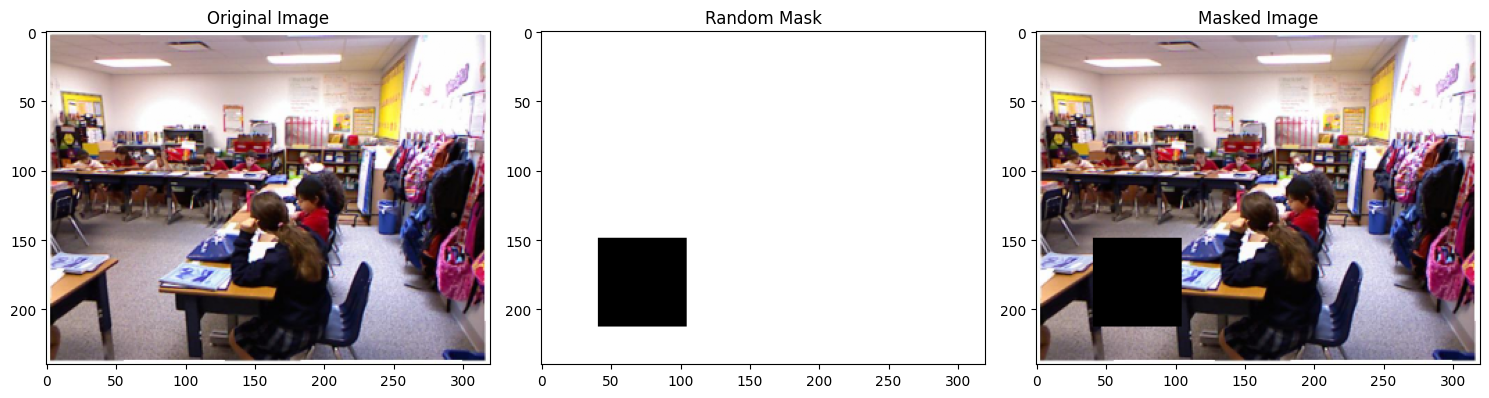

In [8]:
sample_batch = next(iter(train_loader))
show_sample(sample_batch, idx=0)

In [ ]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"); print(device)
model = InpaintingModel(input_channels=3).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.L1Loss()

num_epochs = 20
best_val_loss = float('inf')
for epoch in range(1, num_epochs+1):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_dice = validate(model, val_loader, criterion, device)
    print(f"Epoch {epoch}/{num_epochs} - Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Dice: {val_dice:.4f}")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_inpainting_model.pth")
        print(f"Saved best model with Val Loss: {best_val_loss:.4f}")

cuda


c:\Users\user\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 2535/2535 [07:50<00:00,  5.38it/s]


Epoch 1/20 - Train Loss: 0.0461 | Val Loss: 0.0280 | Val Dice: 0.6339
Saved best model with Val Loss: 0.0280


 80%|████████  | 2038/2535 [06:37<03:09,  2.62it/s]

mps
SSD between Inpainted vs GT: 51.360355
SSD between Masked vs GT: 3887.7922
SSD between Inpainted vs GT: 147.83714
SSD between Masked vs GT: 3419.0469
SSD between Inpainted vs GT: 43.21154
SSD between Masked vs GT: 6762.4995


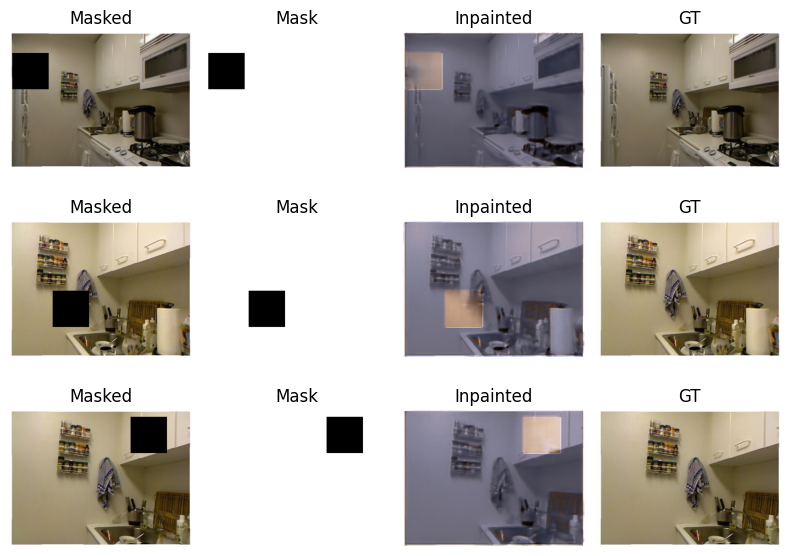

In [ ]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"); print(device)
model = InpaintingModel(input_channels=3).to(device)
model.load_state_dict(torch.load("best_inpainting_model.pth", map_location=device))
model.eval()

# Visualization: select a few samples from the test dataset.
sample_idx = 54
rows = 3
samples = [test_dataset[i] for i in range(sample_idx, sample_idx + rows)]
masked_images = torch.stack([s["masked_image"] for s in samples], dim=0)
masks = torch.stack([s["mask"] for s in samples], dim=0)
sample_labels = torch.stack([s["image"] for s in samples], dim=0)

inpainted_images = []
with torch.no_grad():
    for i in range(rows):
        input_masked = masked_images[i].unsqueeze(0).to(device)
        input_mask = masks[i].unsqueeze(0).to(device)
        pred = model(input_masked, input_mask)
        inpainted_images.append(pred.squeeze(0).cpu())

fig, axs = plt.subplots(nrows=rows, ncols=4, figsize=(8, 2*rows))
for i in range(rows):
    masked_np = masked_images[i].permute(1, 2, 0).cpu().numpy()
    mask_np = masks[i].squeeze(0).cpu().numpy()
    inpainted_np = inpainted_images[i].permute(1, 2, 0).cpu().numpy()
    label_np = sample_labels[i].permute(1, 2, 0).cpu().numpy()
    
    print("SSD between Inpainted vs GT:", np.sum((inpainted_np - label_np)**2))
    print("SSD between Masked vs GT:", np.sum((masked_np - label_np)**2))

    axs[i, 0].imshow(masked_np)
    axs[i, 0].set_title("Masked")
    axs[i, 0].axis("off")
    
    axs[i, 1].imshow(mask_np, cmap="gray")
    axs[i, 1].set_title("Mask")
    axs[i, 1].axis("off")
    
    axs[i, 2].imshow(inpainted_np)
    axs[i, 2].set_title("Inpainted")
    axs[i, 2].axis("off")
    
    axs[i, 3].imshow(label_np)
    axs[i, 3].set_title("GT")
    axs[i, 3].axis("off")
    
plt.tight_layout()
plt.show()